<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ вакансий из HeadHunter
   

In [121]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import json
from collections import Counter
import numpy as np
from re import split

In [122]:

# Загрузка конфигурации из JSON-файла
with open('config.json', 'r') as file:
    config = json.load(file)

# Получение значений из конфигурации
DBNAME = config['dbname']
USER = config['user']
PASSWORD = config['password']
HOST = config['host']
PORT = config['port']

connection = psycopg2.connect(
    dbname=DBNAME,
    user=USER,
    host=HOST,
    password=PASSWORD,
    port=PORT
)

# Юнит 3. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [123]:
# текст запроса

query_vacancies_count = f'''SELECT COUNT(*) as vacancies_count
                            FROM public.vacancies;
                         '''



In [124]:
# результат запроса
df = pd.read_sql_query(query_vacancies_count, connection)
df

C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\273012195.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_vacancies_count, connection)


,vacancies_count
0,49197


2. Напишите запрос, который посчитает количество работодателей (таблица employers). 

In [125]:
# текст запроса
query_employers_count = f'''SELECT COUNT(*) as employers_count
                            FROM public.employers;
                         '''



In [126]:
# результат запроса

df = pd.read_sql_query(query_employers_count, connection)
df

,employers_count
0,23501


3. Посчитате с помощью запроса количество регионов (таблица areas).

In [127]:
# текст запроса
query_areas_count = f'''SELECT COUNT(*) as areas_count
                        FROM public.areas;
                     '''



In [128]:
# результат запроса

df = pd.read_sql_query(query_areas_count, connection)
df

C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\2034896875.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_areas_count, connection)


,areas_count
0,1362


4. Посчитате с помощью запроса количество сфер деятельности в базе (таблица industries).

In [129]:
# текст запроса
query_industries_count = f'''SELECT COUNT(*) as industries_count
                             FROM public.industries;
                          '''



In [130]:
# результат запроса

df = pd.read_sql_query(query_industries_count, connection)
df

,industries_count
0,294


***

# Выводы по предварительному анализу данных

В базе данных имеется информация о 49197 вакансиях, предлагаемых 23501 работодателями.
Вакансии распространены по 1362 регионам, что показывает широкое географическое разнообразие возможностей занятости.
Сферы деятельности также представлены в широком диапазоне, с 294 различными сферами, что указывает на многообразие возможностей для соискателей.
Но несмотря на широкую географию, в основном, наибольшее количество вакансий сосредоточено в крупных городах, что мы можем проиллюстрировать с помощью гистограммы распределения библиотеки Matplotlib.

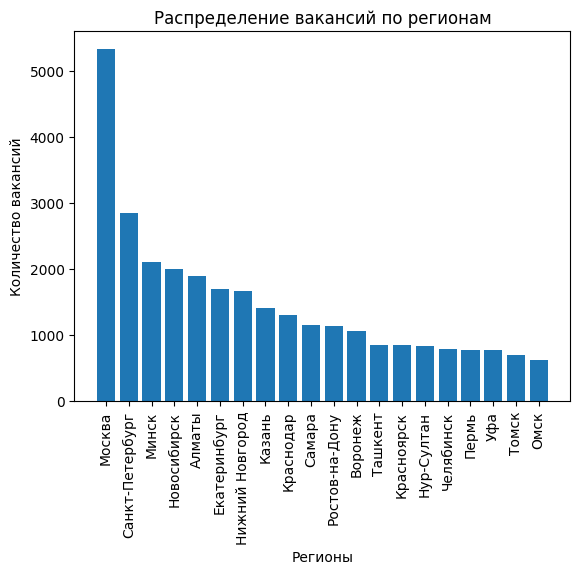

In [131]:
# Запрос для получения количества вакансий по регионам
query_vacancies_by_area = f'''SELECT a.name as area_name, COUNT(v.id) as vacancies_count
                               FROM public.vacancies v
                               JOIN public.areas a ON a.id = v.area_id
                               GROUP BY a.name
                               ORDER BY vacancies_count DESC
                               LIMIT 20;
                            '''

# Выполнение запроса и получение данных
with connection.cursor() as cursor:
    cursor.execute(query_vacancies_by_area)
    vacancies_by_area_data = cursor.fetchall()

# Разделение данных на отдельные списки
areas, vacancies_counts = zip(*vacancies_by_area_data)

# Создание гистограммы
plt.bar(areas, vacancies_counts)
plt.xlabel('Регионы')
plt.ylabel('Количество вакансий')
plt.title('Распределение вакансий по регионам')
plt.xticks(rotation=90)
plt.show()


# Юнит 4. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (cnt) вакансий в каждом регионе (area).
Отсортируйте по количеству вакансий в порядке убывания.

In [132]:
query_vacancies_by_area_cnt = f'''SELECT a.name AS area, COUNT(v.id) AS cnt
                               FROM public.vacancies v
                               JOIN public.areas a ON v.area_id = a.id
                               GROUP BY a.name
                               ORDER BY cnt DESC;
                            '''

In [133]:
# результат запроса

df = pd.read_sql_query(query_vacancies_by_area_cnt, connection)
df

,area,cnt
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892
...,...,...
764,Тарко-Сале,1
765,Новоаннинский,1
766,Бирск,1
767,Сасово,1


2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [134]:
query_salary_from_or_salary_to = f'''SELECT COUNT(id) AS vacancies_with_salary
                               FROM public.vacancies
                               WHERE salary_from IS NOT NULL OR salary_to IS NOT NULL;
                            '''

In [135]:
# результат запроса

df = pd.read_sql_query(query_salary_from_or_salary_to, connection)
df

C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\3985443556.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_salary_from_or_salary_to, connection)


,vacancies_with_salary
0,24073


3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до целого.

In [136]:
query_avg_salaries = f'''
SELECT ROUND(AVG(salary_from)) AS avg_salary_from,
       ROUND(AVG(salary_to)) AS avg_salary_to
FROM vacancies
WHERE salary_from IS NOT NULL OR salary_to IS NOT NULL;
'''


In [137]:
# результат запроса

df = pd.read_sql_query(query_avg_salaries, connection)
df

C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\493691691.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_avg_salaries, connection)


,avg_salary_from,avg_salary_to
0,71065.0,110537.0


4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [138]:
query_schedule_employment = f'''
SELECT schedule, employment, COUNT(*) AS vacancies_count
FROM vacancies
GROUP BY schedule, employment
ORDER BY vacancies_count DESC;
'''


In [139]:
# результат запроса

df = pd.read_sql_query(query_schedule_employment, connection)
df

C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\1674341733.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_schedule_employment, connection)


,schedule,employment,vacancies_count
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593
3,Удаленная работа,Частичная занятость,1312
4,Сменный график,Полная занятость,940
5,Полный день,Стажировка,569
6,Вахтовый метод,Полная занятость,367
7,Полный день,Частичная занятость,347
8,Гибкий график,Частичная занятость,312
9,Полный день,Проектная работа,141


5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта. 

In [140]:
query_experience = f'''
SELECT experience, COUNT(*) AS vacancies_count
FROM vacancies
GROUP BY experience
ORDER BY vacancies_count ASC;
'''


In [141]:
# результат запроса

df = pd.read_sql_query(query_experience, connection)
df

C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\1418971104.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_experience, connection)


,experience,vacancies_count
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


***

# Выводы по детальному анализу вакансий

Исходя из полученных данных, можно сделать следующие выводы и предположения:

* Вакансии сосредоточены в крупных городах, таких как Москва, Санкт-Петербург, Минск, Новосибирск и Алматы. Это ожидаемо, поскольку крупные города являются крупными деловыми и научными центрами.

* Значительное количество вакансий (24073) имеет указанную зарплатную вилку, что позволяет соискателям лучше понимать, какие ожидания у работодателей в отношении заработной платы.

* Средняя нижняя граница зарплатной вилки составляет 71,065 рублей, а верхняя - 110,537 рублей. Эти данные могут служить ориентиром для соискателей и помочь им определить свои финансовые ожидания при поиске работы.

* Самые популярные сочетания типа рабочего графика и типа трудоустройства:

Полный день - Полная занятость (наиболее распространенный вариант)

Удаленная работа - Полная занятость (отражает тенденцию к удаленной работе, например, в IT-сфере)

Гибкий график - Полная занятость

Эти данные показывают, что работодатели предпочитают нанимать специалистов на полную ставку, но также становится всё более популярной удаленная работа и гибкий график.

* Опыт работы в вакансиях:

Более 6 лет (наименее популярный), от 1 года до 3 лет (наиболее популярный)

Выводы по опыту работы говорят о том, что большинство вакансий ориентировано на кандидатов со средним опытом работы (от 1 до 6 лет). Вакансий для начинающих специалистов (без опыта) и для тех, кто имеет более 6 лет опыта, меньше.

Исходя из этих выводов, можно предположить, что рынок труда на момент создания базы данных показывал активное развитие и спрос на специалистов разного уровня опыта, особенно ценятся кандидаты со средним опытом. Удаленная работа и гибкий график также становятся более популярными вариантами трудоустройства, что отражает изменение предпочтений и потребностей современных специалистов и работодателей.

Соискателям следует учитывать данные о средних зарплатах при формировании своих ожиданий, а работодатели могут использовать эту информацию для корректировки своих предложений и привлечения кандидатов.

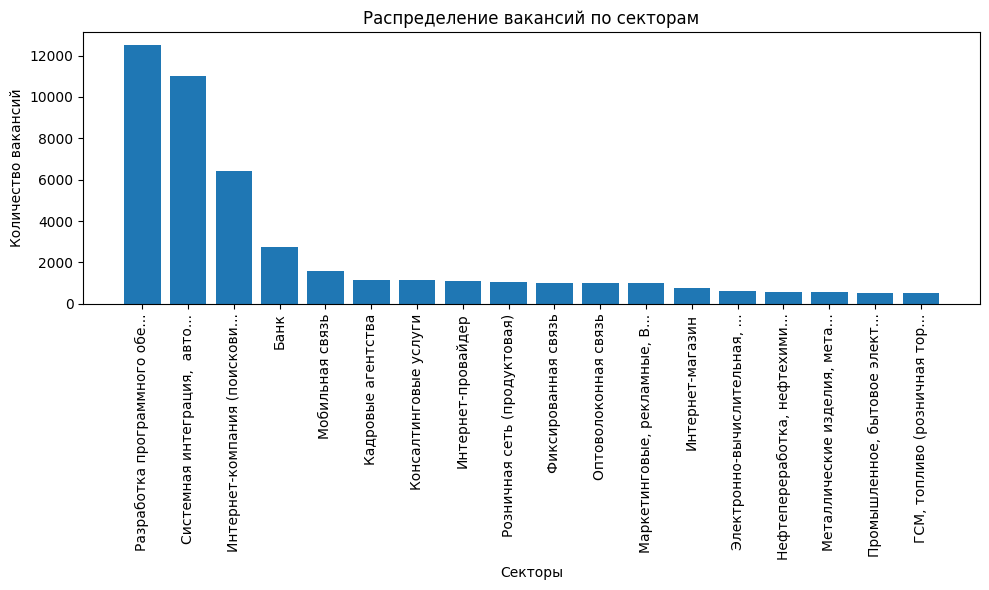

In [142]:
# Гистограмма распределения вакансий по секторам:

# Запрос для получения количества вакансий по секторам
query_vacancies_by_industry = f'''SELECT i.name as industry_name, COUNT(v.id) as vacancies_count
                                  FROM public.vacancies v
                                  JOIN public.employers_industries ei ON ei.employer_id = v.employer_id
                                  JOIN public.industries i ON i.id = ei.industry_id
                                  GROUP BY i.name
                                  ORDER BY vacancies_count DESC
                                  LIMIT 20;
                               '''

# Выполнение запроса и получение данных
with connection.cursor() as cursor:
    cursor.execute(query_vacancies_by_industry)
    vacancies_by_industry_data = cursor.fetchall()

# Разделение данных на отдельные списки
industries, vacancies_counts = zip(*vacancies_by_industry_data)

# Функция для сокращения названия сектора (если необходимо)
def shorten_industry_name(name, max_length=30):
    if len(name) > max_length:
        return name[:max_length-3] + "..."
    else:
        return name

# Создание списка сокращенных названий секторов
shortened_industries = [shorten_industry_name(industry) for industry in industries]

# Создание гистограммы
plt.figure(figsize=(10, 6))
plt.bar(shortened_industries, vacancies_counts)
plt.xlabel('Секторы')
plt.ylabel('Количество вакансий')
plt.title('Распределение вакансий по секторам')
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()



Ниже график показывает соотношение удаленных работ и работ с гибким графиком в разных сферах деятельности. График визуализирует процент удаленных работ и работ с гибким графиком от общего числа вакансий в каждой сфере деятельности. Это поможет определить тенденции по удаленной работе и гибкому графику в разных отраслях.


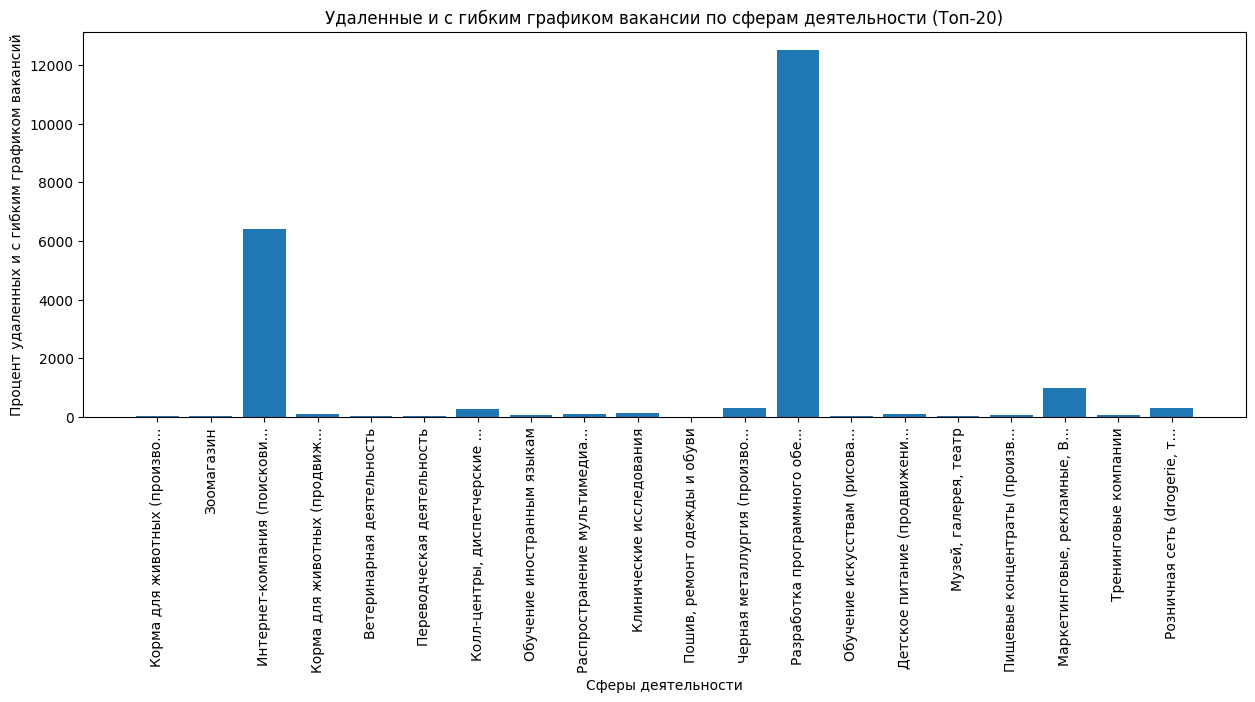

In [143]:
query_remote_flexible_by_industry = f'''
SELECT i.name as industry, 
       COUNT(v.id) as total_vacancies, 
       SUM(CASE WHEN v.schedule = 'Удаленная работа' OR v.schedule = 'Гибкий график' THEN 1 ELSE 0 END) as remote_flexible_vacancies,
       ROUND(100.0 * SUM(CASE WHEN v.schedule = 'Удаленная работа' OR v.schedule = 'Гибкий график' THEN 1 ELSE 0 END) / COUNT(v.id), 2) as remote_flexible_vacancies_percentage
FROM public.vacancies v
JOIN public.employers_industries ei ON v.employer_id = ei.employer_id
JOIN public.industries i ON ei.industry_id = i.id
GROUP BY i.name
ORDER BY remote_flexible_vacancies_percentage DESC
'''
with connection.cursor() as cursor:
    cursor.execute(query_remote_flexible_by_industry)
    remote_flexible_by_industry_data = cursor.fetchall()


# Разделение данных на отдельные списки
industries, remote_flexible_percentages_industries = zip(*[(row[0], row[1]) for row in remote_flexible_by_industry_data[:20]])

# Функция для сокращения названия сектора (если необходимо)
def shorten_industry_name(name, max_length=30):
    if len(name) > max_length:
        return name[:max_length-3] + "..."
    else:
        return name

# Создание списка сокращенных названий секторов и городов
shortened_industries = [shorten_industry_name(industry) for industry in industries]

# График для сфер деятельности
plt.figure(figsize=(15, 5))
plt.bar(shortened_industries, remote_flexible_percentages_industries)
plt.xticks(rotation=90)
plt.xlabel("Сферы деятельности")
plt.ylabel("Процент удаленных и с гибким графиком вакансий")
plt.title("Удаленные и с гибким графиком вакансии по сферам деятельности (Топ-20)")
plt.show()

# Юнит 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [144]:
query_top_employers = f'''
SELECT e.name AS employer_name, 
       COUNT(v.id) AS total_vacancies
FROM public.vacancies v
JOIN public.employers e ON v.employer_id = e.id
GROUP BY e.name
ORDER BY total_vacancies DESC
LIMIT 5
'''

with connection.cursor() as cursor:
    cursor.execute(query_top_employers)
    top_employers_data = cursor.fetchall()

first_place_employer = top_employers_data[0][0]
fifth_place_employer = top_employers_data[4][0]

display(f"Первое место по количеству вакансий занимает: {first_place_employer}")
display(f"Пятое место по количеству вакансий занимает: {fifth_place_employer}")


'Первое место по количеству вакансий занимает: Яндекс'

'Пятое место по количеству вакансий занимает: Газпром нефть'

In [145]:
# результат запроса

df = pd.read_sql_query(query_top_employers, connection)
df

C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\529219077.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_top_employers, connection)


,employer_name,total_vacancies
0,Яндекс,1933
1,Ростелеком,491
2,Тинькофф,444
3,СБЕР,428
4,Газпром нефть,331


2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [146]:
query_employers_vacancies_by_area = f'''
WITH region_vacancies AS (
    SELECT a.id AS area_id,
           COUNT(v.id) AS vacancies_count
    FROM public.areas a
    LEFT JOIN public.vacancies v ON a.id = v.area_id
    GROUP BY a.id
),

region_employers AS (
    SELECT a.id AS area_id,
           COUNT(e.id) AS employers_count
    FROM public.areas a
    LEFT JOIN public.employers e ON a.id = e.area
    GROUP BY a.id
)

SELECT a.name AS region,
       rv.vacancies_count,
       re.employers_count
FROM public.areas a
JOIN region_vacancies rv ON a.id = rv.area_id
JOIN region_employers re ON a.id = re.area_id
WHERE rv.vacancies_count = 0
ORDER BY re.employers_count DESC, a.name
LIMIT 1;

'''


In [147]:
# результат запроса

df = pd.read_sql_query(query_employers_vacancies_by_area, connection)
df

C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\1858683524.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_employers_vacancies_by_area, connection)


,region,vacancies_count,employers_count
0,Россия,0,410


3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [148]:
query_employers_regions_vacancies_max = f'''
WITH employer_regions AS (
    SELECT e.id AS employer_id,
           e.name AS employer_name,
           COUNT(DISTINCT a.id) AS regions_count
    FROM public.vacancies v
    JOIN public.employers e ON v.employer_id = e.id
    JOIN public.areas a ON v.area_id = a.id
    GROUP BY e.id
)

SELECT MAX(regions_count) AS max_regions_count
FROM employer_regions;
'''

In [149]:
# результат запроса

df = pd.read_sql_query(query_employers_regions_vacancies_max, connection)
df

C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\2737317825.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_employers_regions_vacancies_max, connection)


,max_regions_count
0,181


In [150]:
query_employers_regions_vacancies = f'''
SELECT e.name AS employer_name,
        COUNT(DISTINCT a.id) AS regions_count
FROM public.vacancies v
JOIN public.employers e ON v.employer_id = e.id
JOIN public.areas a ON v.area_id = a.id
GROUP BY e.id
ORDER BY regions_count DESC;
'''

In [151]:
# результат запроса

df = pd.read_sql_query(query_employers_regions_vacancies, connection)
df

C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\2294839697.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_employers_regions_vacancies, connection)


,employer_name,regions_count
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71
...,...,...
14901,НПП Авиатрон,1
14902,Центр дистанционных торгов,1
14903,Городские Телекоммуникационные Системы,1
14904,"Введенский, Отель",1


4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности. 

In [152]:
query_employers_industry_none = f'''
SELECT COUNT(*)
FROM public.employers e
WHERE NOT EXISTS (
    SELECT 1
    FROM public.employers_industries ei
    WHERE e.id = ei.employer_id
);
'''


In [153]:
# результат запроса

df = pd.read_sql_query(query_employers_industry_none, connection)
df

C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\2776715238.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_employers_industry_none, connection)


,count
0,8419


5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [154]:
query_employers_limit_industry = f'''
SELECT e.name
FROM public.employers e
WHERE (
    SELECT COUNT(*)
    FROM public.employers_industries ei
    WHERE e.id = ei.employer_id
) = 4
ORDER BY e.name
LIMIT 1
OFFSET 2;
'''


In [155]:
# результат запроса

df = pd.read_sql_query(query_employers_limit_industry, connection)
df

C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\2230153513.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_employers_limit_industry, connection)


,name
0,2ГИС


6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


In [156]:
query_software_development_employers_count = '''
SELECT COUNT(DISTINCT ei.employer_id)
FROM public.employers_industries ei
JOIN public.industries i ON ei.industry_id = i.id
WHERE i.name = 'Разработка программного обеспечения';
'''

software_development_employers_count = pd.read_sql_query(query_software_development_employers_count, connection).iloc[0, 0]

print(f"Количество работодателей, у которых сфера деятельности указана как 'Разработка программного обеспечения': {software_development_employers_count}")


C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\3073126049.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  software_development_employers_count = pd.read_sql_query(query_software_development_employers_count, connection).iloc[0, 0]


Количество работодателей, у которых сфера деятельности указана как 'Разработка программного обеспечения': 3553


In [157]:
# результат запроса

df = pd.read_sql_query(query_software_development_employers_count, connection)
df

C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\2206040051.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_software_development_employers_count, connection)


,count
0,3553


7. Для компании «Яндекс» выведите список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

Список городов-милионников надо взять [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

Если возникнут трудности с этим задание посмотрите материалы модуля  PYTHON-17. Как получать данные из веб-источников и API. 

In [158]:
url = 'https://ru.wikipedia.org/wiki/Города-миллионеры_России'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

h3 = soup.find('span', {'id': 'Список_городов-миллионеров'}).parent
table = h3.find_next_sibling('table')

cities = []
for row in table.find_all('tr')[1:]:
    city = row.find_all('td')[1].get_text(strip=True)
    cities.append(city)

print(cities)


['Москва', 'Санкт-Петербург', 'Новосибирск', 'Екатеринбург', 'Казань', 'Нижний Новгород', 'Красноярск', 'Челябинск', 'Самара', 'Уфа', 'Ростов-на-Дону', 'Краснодар', 'Омск', 'Воронеж', 'Пермь', 'Волгоград']


In [159]:
cities_placeholder = ', '.join(['%s'] * len(cities))

query_yandex = f'''
WITH yandex AS (
    SELECT id
    FROM public.employers
    WHERE name = 'Яндекс'
),
yandex_vacancies AS (
    SELECT area_id, COUNT(*) AS count
    FROM public.vacancies
    WHERE employer_id = (SELECT id FROM yandex)
    GROUP BY area_id
),
million_cities AS (
    SELECT id, name
    FROM public.areas
    WHERE name IN ({cities_placeholder})
)

SELECT mc.name AS city, yv.count AS vacancies_count
FROM million_cities mc
LEFT JOIN yandex_vacancies yv ON mc.id = yv.area_id
WHERE yv.count IS NOT NULL
ORDER BY yv.count
'''

with connection.cursor() as cursor:
    cursor.execute(query_yandex, tuple(cities))
    result = cursor.fetchall()

# Считаем общее количество вакансий и добавляем строку Total в результат
total_vacancies = sum(row[1] for row in result)
result.append(('Total', total_vacancies))

# Выводим результат
for row in result:
    print(row)


('Омск', 21)
('Челябинск', 22)
('Красноярск', 23)
('Волгоград', 24)
('Казань', 25)
('Ростов-на-Дону', 25)
('Пермь', 25)
('Уфа', 26)
('Самара', 26)
('Краснодар', 30)
('Воронеж', 32)
('Новосибирск', 35)
('Нижний Новгород', 36)
('Екатеринбург', 39)
('Санкт-Петербург', 42)
('Москва', 54)
('Total', 485)


***

# Выводы по анализу работодателей

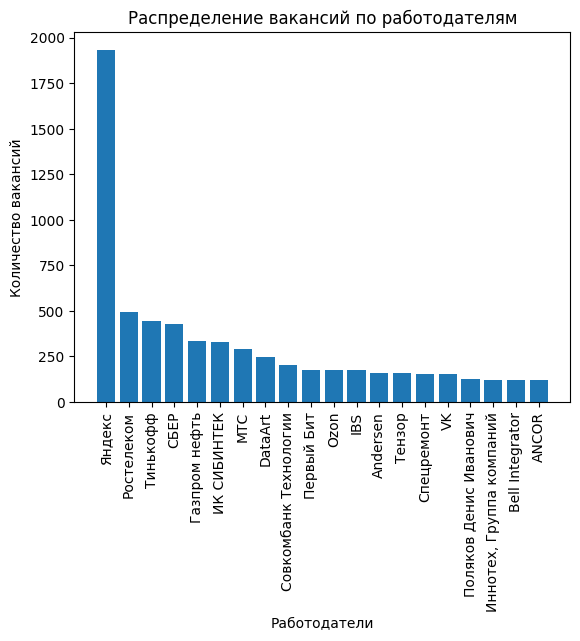

In [160]:


# Гистограмма распределения вакансий по работодателям:

# Запрос для получения количества вакансий по работодателям
query_vacancies_by_employer = f'''SELECT e.name as employer_name, COUNT(v.id) as vacancies_count
                                  FROM public.vacancies v
                                  JOIN public.employers e ON e.id = v.employer_id
                                  GROUP BY e.name
                                  ORDER BY vacancies_count DESC
                                  LIMIT 20;
                               '''

# Выполнение запроса и получение данных
with connection.cursor() as cursor:
    cursor.execute(query_vacancies_by_employer)
    vacancies_by_employer_data = cursor.fetchall()

# Разделение данных на отдельные списки
employers, vacancies_counts = zip(*vacancies_by_employer_data)

# Создание гистограммы
plt.bar(employers, vacancies_counts)
plt.xlabel('Работодатели')
plt.ylabel('Количество вакансий')
plt.title('Распределение вакансий по работодателям')
plt.xticks(rotation=90)
plt.show()


C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\2865899684.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_optimized = pd.read_sql_query(query_top_employers_by_regions_heatmap_optimized, connection)


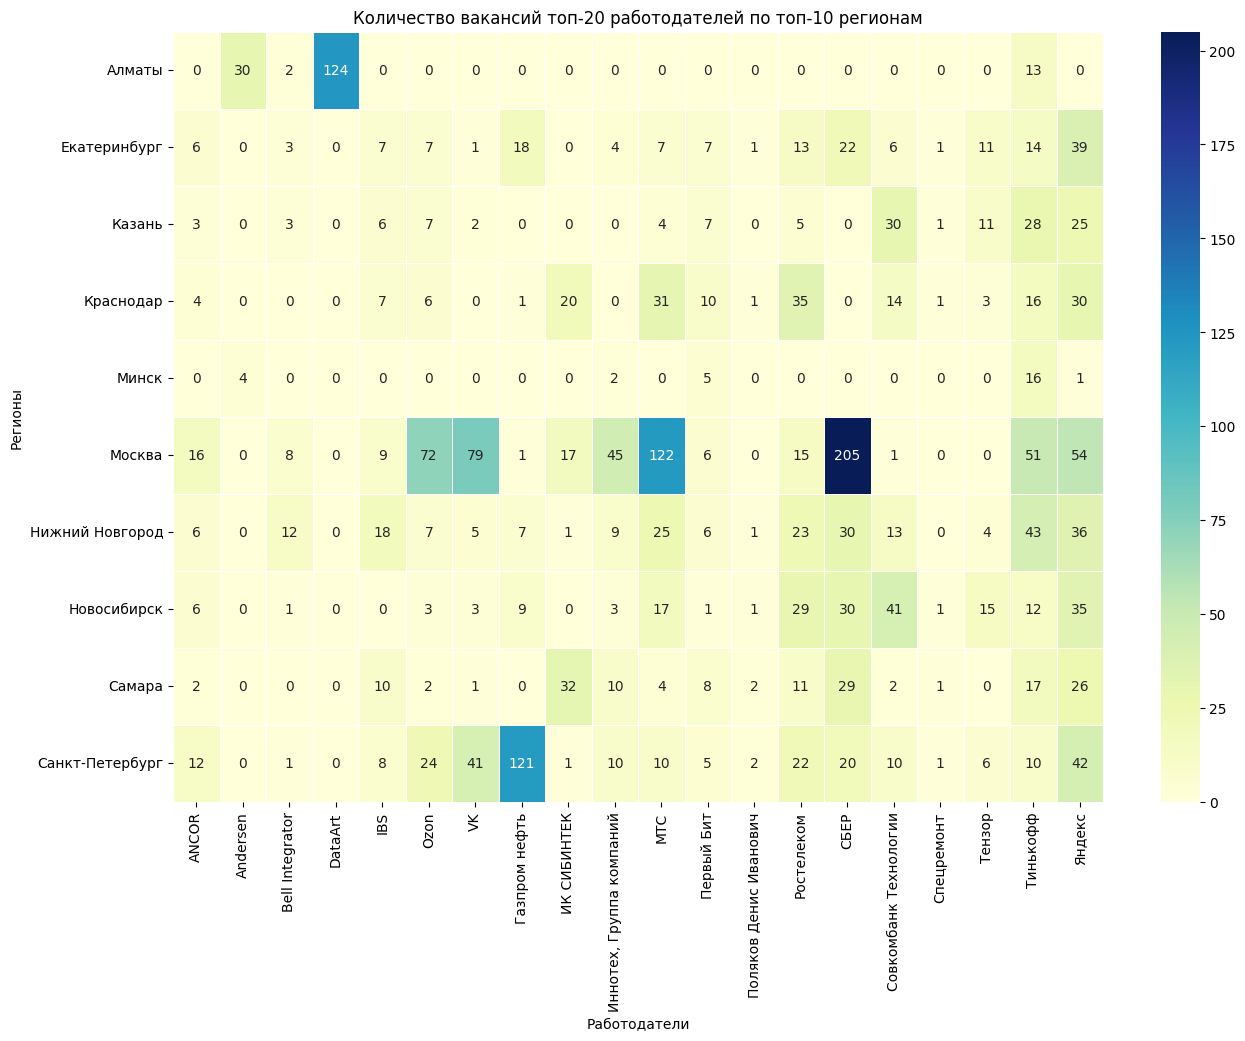

In [161]:
query_top_employers_by_regions_heatmap_optimized = '''
WITH top_employers AS (
    SELECT e.id AS employer_id,
           e.name AS employer_name,
           COUNT(v.id) AS vacancies_count
    FROM public.vacancies v
    JOIN public.employers e ON v.employer_id = e.id
    GROUP BY e.id
    ORDER BY vacancies_count DESC
    LIMIT 20
),
top_areas AS (
    SELECT a.id AS area_id,
           a.name AS area_name,
           COUNT(v.id) AS vacancies_count
    FROM public.vacancies v
    JOIN public.areas a ON v.area_id = a.id
    GROUP BY a.id
    ORDER BY vacancies_count DESC
    LIMIT 10
)

SELECT ta.area_name,
       te.employer_name,
       COUNT(v.id) AS vacancies_count
FROM top_areas ta
CROSS JOIN top_employers te
LEFT JOIN public.vacancies v ON v.area_id = ta.area_id AND v.employer_id = te.employer_id
GROUP BY ta.area_name, te.employer_name
ORDER BY ta.area_name, te.employer_name;
'''

# Выполнение запроса и сохранение результата в DataFrame
df_optimized = pd.read_sql_query(query_top_employers_by_regions_heatmap_optimized, connection)

# Создание сводной таблицы для heatmap
pivot_table_optimized = df_optimized.pivot_table(index='area_name', columns='employer_name', values='vacancies_count', fill_value=0)

# Создание тепловой карты
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_table_optimized, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
plt.xlabel("Работодатели")
plt.ylabel("Регионы")
plt.title("Количество вакансий топ-20 работодателей по топ-10 регионам")
plt.show()


C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\3616480613.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_software_development_vacancies_by_employer = pd.read_sql_query(query_software_development_vacancies_by_employer, connection)


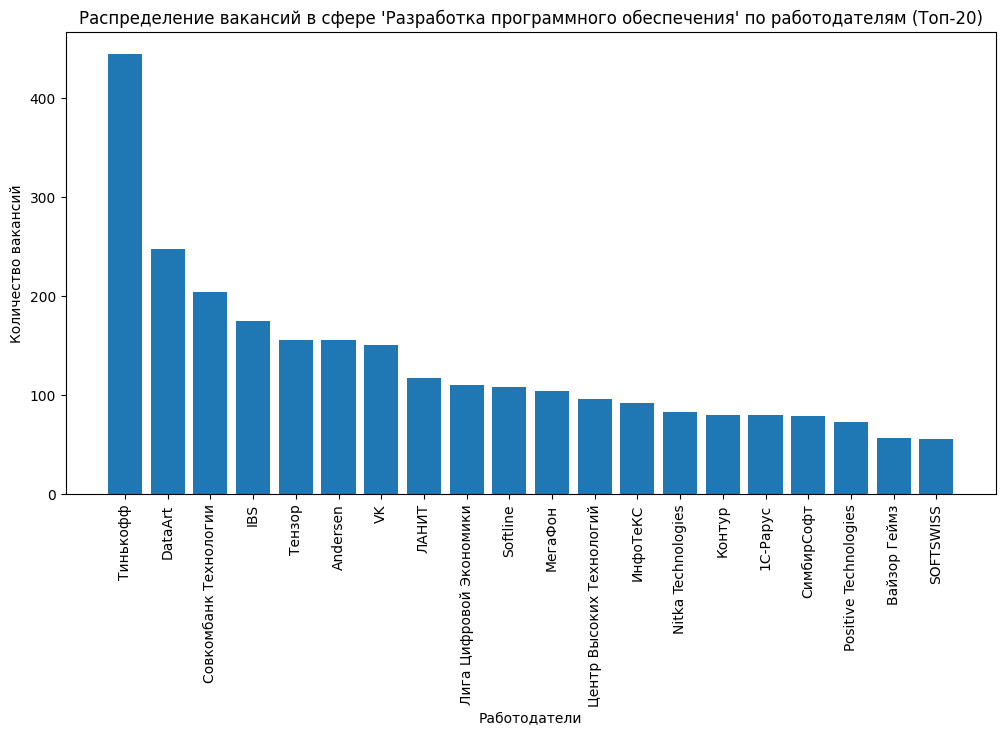

In [162]:
query_software_development_vacancies_by_employer = '''
SELECT e.name AS employer_name, COUNT(v.id) AS vacancies_count
FROM public.vacancies v
JOIN public.employers e ON v.employer_id = e.id
JOIN public.employers_industries ei ON e.id = ei.employer_id
JOIN public.industries i ON ei.industry_id = i.id
WHERE i.name = 'Разработка программного обеспечения'
GROUP BY e.name
ORDER BY vacancies_count DESC;
'''

df_software_development_vacancies_by_employer = pd.read_sql_query(query_software_development_vacancies_by_employer, connection)


# Ограничим вывод до топ-20 работодателей
top_employers = df_software_development_vacancies_by_employer.head(20)

# Создание графика
plt.figure(figsize=(12, 6))
plt.bar(top_employers['employer_name'], top_employers['vacancies_count'])
plt.xticks(rotation=90)
plt.xlabel("Работодатели")
plt.ylabel("Количество вакансий")
plt.title("Распределение вакансий в сфере 'Разработка программного обеспечения' по работодателям (Топ-20)")

plt.show()


C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\1326154158.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_software_development = pd.read_sql_query(query_software_development_vacancies_heatmap, connection)


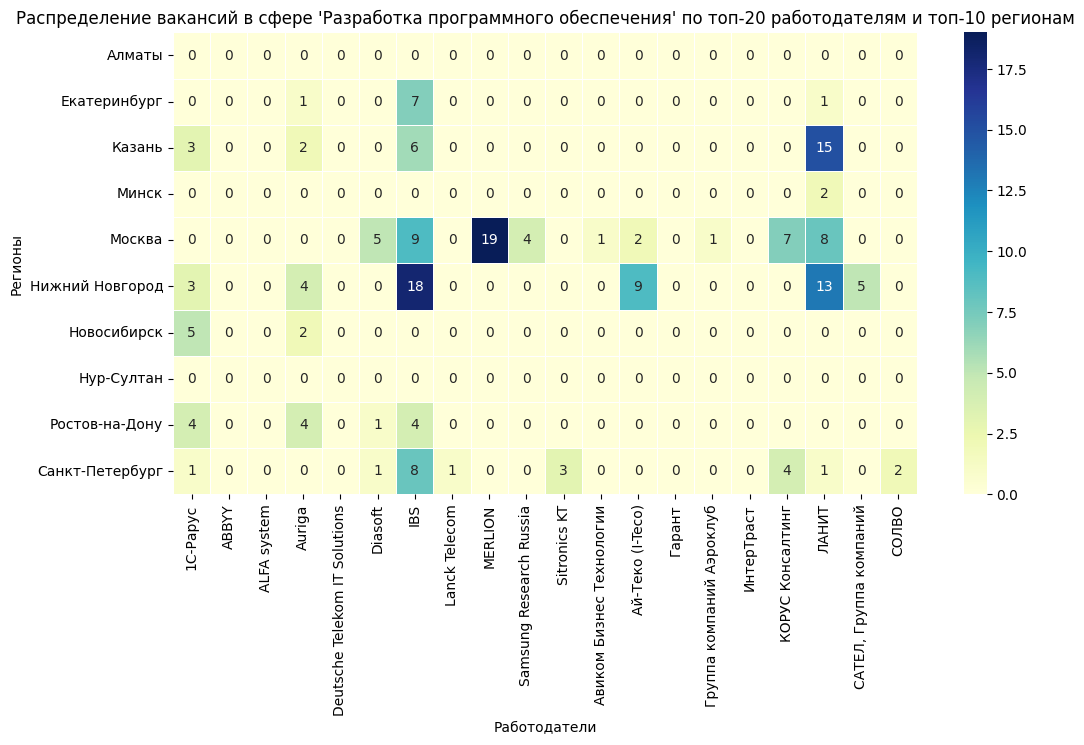

In [163]:
query_software_development_vacancies_heatmap = '''
WITH top_employers AS (
    SELECT e.id AS employer_id, e.name AS employer_name
    FROM public.employers e
    JOIN public.employers_industries ei ON e.id = ei.employer_id
    JOIN public.industries i ON ei.industry_id = i.id
    WHERE i.name = 'Разработка программного обеспечения'
    GROUP BY e.id, e.name
    ORDER BY COUNT(*) DESC
    LIMIT 20
),
top_areas AS (
    SELECT a.id AS area_id, a.name AS area_name
    FROM public.areas a
    JOIN public.vacancies v ON a.id = v.area_id
    JOIN public.employers e ON v.employer_id = e.id
    JOIN public.employers_industries ei ON e.id = ei.employer_id
    JOIN public.industries i ON ei.industry_id = i.id
    WHERE i.name = 'Разработка программного обеспечения'
    GROUP BY a.id, a.name
    ORDER BY COUNT(*) DESC
    LIMIT 10
)

SELECT ta.area_name,
       te.employer_name,
       COUNT(v.id) AS vacancies_count
FROM top_areas ta
CROSS JOIN top_employers te
LEFT JOIN public.vacancies v ON v.area_id = ta.area_id AND v.employer_id = te.employer_id
JOIN public.employers_industries ei ON te.employer_id = ei.employer_id
JOIN public.industries i ON ei.industry_id = i.id
WHERE i.name = 'Разработка программного обеспечения'
GROUP BY ta.area_name, te.employer_name
ORDER BY ta.area_name, te.employer_name;
'''

# Выполнение запроса и сохранение результата в DataFrame
df_software_development = pd.read_sql_query(query_software_development_vacancies_heatmap, connection)

# Создание сводной таблицы для heatmap
pivot_table_software_development = df_software_development.pivot_table(index='area_name', columns='employer_name', values='vacancies_count', fill_value=0)

# Построение тепловой карты
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table_software_development, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5)
plt.title("Распределение вакансий в сфере 'Разработка программного обеспечения' по топ-20 работодателям и топ-10 регионам")
plt.xlabel("Работодатели")
plt.ylabel("Регионы")
plt.show()



# Юнит 6. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

*Подсказка: Обратите внимание, что названия вакансий могут быть написаны в любом регистре.* 


In [164]:
query_data_related_vacancies = f"""
SELECT COUNT(*) as count
FROM public.vacancies
WHERE LOWER(name) LIKE '%data%' OR LOWER(name) LIKE '%данн%';
"""


In [165]:
# результат запроса

df = pd.read_sql_query(query_data_related_vacancies, connection)
display("Количество вакансий, относящихся к данным:", df["count"][0])

C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\1079364218.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_data_related_vacancies, connection)


'Количество вакансий, относящихся к данным:'

1771

2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? 
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.
 

In [166]:
query_junior_data_scientist_vacancies = f"""
SELECT COUNT(*) as count
FROM public.vacancies
WHERE (
    LOWER(name) LIKE '%data scientist%' OR
    LOWER(name) LIKE '%data science%' OR
    LOWER(name) LIKE '%исследователь данных%' OR
    (LOWER(name) LIKE '%ml%' AND LOWER(name) NOT LIKE '%html%') OR
    LOWER(name) LIKE '%machine learning%' OR
    LOWER(name) LIKE '%машинн%обучен%'
) AND (
    LOWER(name) LIKE '%junior%' OR
    LOWER(experience) = 'нет опыта' OR
    LOWER(employment) = 'стажировка'
);
"""

In [167]:
# результат запроса

df = pd.read_sql_query(query_junior_data_scientist_vacancies, connection)
df

C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\1689916215.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_junior_data_scientist_vacancies, connection)


,count
0,51


3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

** Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [168]:
query_data_science_sql_postgres = f"""
SELECT COUNT(*) 
FROM vacancies
WHERE (
    (LOWER(name) LIKE '%data scientist%'
    OR LOWER(name) LIKE '%data science%'
    OR LOWER(name) LIKE '%исследователь данных%'
    OR LOWER(name) LIKE '%machine learning%'
    OR name LIKE '%ML%' AND name NOT LIKE '%HTML%'
    OR LOWER(name) LIKE '%машинн%обучен%')
)
AND (
    (LOWER(key_skills) LIKE '%sql%')
    OR (LOWER(key_skills) LIKE '%postgres%')
);
"""

In [169]:
# результат запроса

df = pd.read_sql_query(query_data_science_sql_postgres, connection)
df

C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\1690099404.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_data_science_sql_postgres, connection)


,count
0,201


4. Проверьте, насколько популярен Python в требованиях работодателей к DS.Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

** Это можно сделать помощью запроса, аналогичного предыдущему.*

In [170]:
query_data_science_python = f"""
SELECT COUNT(*) 
FROM vacancies
WHERE (
    (LOWER(name) LIKE '%data scientist%'
    OR LOWER(name) LIKE '%data science%'
    OR LOWER(name) LIKE '%исследователь данных%'
    OR LOWER(name) LIKE '%machine learning%'
    OR name LIKE '%ML%' AND name NOT LIKE '%HTML%'
    OR LOWER(name) LIKE '%машинн%обучен%')
)
AND (
    LOWER(key_skills) LIKE '%python%'
);
"""

In [171]:
# результат запроса

df = pd.read_sql_query(query_data_science_python, connection)
df

C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\3009388142.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_data_science_python, connection)


,count
0,351


5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до двух знаков после точки-разделителя.

In [172]:
query_avg_key_skills = f"""
SELECT AVG(num_skills)
FROM (
    SELECT id, (LENGTH(key_skills) - LENGTH(REPLACE(key_skills, CHR(9), ''))) + 1 AS num_skills
    FROM vacancies
    WHERE (
        LOWER(name) LIKE '%data scientist%'
        OR LOWER(name) LIKE '%data science%'
        OR LOWER(name) LIKE '%исследователь данных%'
        OR LOWER(name) LIKE '%machine learning%'
        OR name LIKE '%ML%' AND name NOT LIKE '%HTML%'
        OR LOWER(name) LIKE '%машинн%обучен%')
        AND key_skills != ''
) AS vacancy_skills_count;
"""

with connection.cursor() as cursor:
    cursor.execute(query_avg_key_skills)
    result = cursor.fetchone()
    avg_key_skills = round(result[0], 2)
    print(f"Среднее количество ключевых навыков в вакансиях для DS: {avg_key_skills}")


Среднее количество ключевых навыков в вакансиях для DS: 6.41


6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

При решении задачи примите во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, в результате он тоже даст null (посмотрите, что возвращает запрос select 1 + null). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [173]:
query_avg_salary_by_experience = f"""
SELECT experience, ROUND(AVG(salary)) AS avg_salary
FROM (
    SELECT id, experience,
           (COALESCE(salary_from, 0) + COALESCE(salary_to, 0)) / 
           (CASE WHEN salary_from IS NOT NULL AND salary_to IS NOT NULL THEN 2 ELSE 1 END) AS salary
    FROM vacancies
    WHERE (
        LOWER(name) LIKE '%data scientist%'
        OR LOWER(name) LIKE '%data science%'
        OR LOWER(name) LIKE '%исследователь данных%'
        OR LOWER(name) LIKE '%machine learning%'
        OR name LIKE '%ML%' AND name NOT LIKE '%HTML%'
        OR LOWER(name) LIKE '%машинн%обучен%')
        AND (salary_from IS NOT NULL OR salary_to IS NOT NULL)
) AS vacancy_salary
GROUP BY experience;
"""

with connection.cursor() as cursor:
    cursor.execute(query_avg_salary_by_experience)
    results = cursor.fetchall()
    print("Средняя зарплата для DS по уровню опыта:")
    for result in results:
        experience, avg_salary = result
        print(f"{experience}: {avg_salary} рублей")


Средняя зарплата для DS по уровню опыта:
Нет опыта: 74643 рублей
От 1 года до 3 лет: 139675 рублей
От 3 до 6 лет: 243115 рублей


***

# Выводы по предметному анализу

In [174]:
query_avg_salary_by_experience_non_ds = f"""
SELECT experience, ROUND(AVG(salary)) AS avg_salary
FROM (
    SELECT id, experience,
           (COALESCE(salary_from, 0) + COALESCE(salary_to, 0)) / 
           (CASE WHEN salary_from IS NOT NULL AND salary_to IS NOT NULL THEN 2 ELSE 1 END) AS salary
    FROM vacancies
    WHERE (
        LOWER(name) NOT LIKE '%data scientist%'
        AND LOWER(name) NOT LIKE '%data science%'
        AND LOWER(name) NOT LIKE '%исследователь данных%'
        AND LOWER(name) NOT LIKE '%machine learning%'
        AND (LOWER(name) NOT LIKE '%ml%' OR LOWER(name) LIKE '%html%')
        AND LOWER(name) NOT LIKE '%машинн%обучен%')
        AND (salary_from IS NOT NULL OR salary_to IS NOT NULL)
) AS vacancy_salary
GROUP BY experience;
"""

with connection.cursor() as cursor:
    cursor.execute(query_avg_salary_by_experience_non_ds)
    results = cursor.fetchall()
    print("Средняя зарплата для не-DS вакансий по уровню опыта:")
    for result in results:
        experience, avg_salary = result
        print(f"{experience}: {avg_salary} рублей")


Средняя зарплата для не-DS вакансий по уровню опыта:
Более 6 лет: 166317 рублей
Нет опыта: 40425 рублей
От 1 года до 3 лет: 76371 рублей
От 3 до 6 лет: 132310 рублей


Исходя из предоставленных данных, можно сделать следующие выводы:

Средняя зарплата Data Scientist'ов выше, чем у специалистов в других областях для каждого уровня опыта.
Разрыв в зарплате между Data Scientist и другими специалистами увеличивается с ростом опыта.
Для того чтобы показать разницу между зарплатами, можно использовать столбчатый график. 

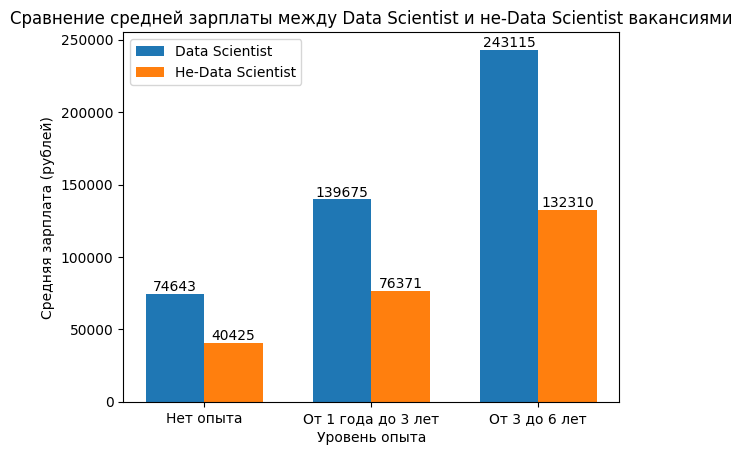

In [186]:
# Зарплаты для DS и не-DS вакансий
ds_salaries = [74643, 139675, 243115]
non_ds_salaries = [40425, 76371, 132310]

# Категории опыта
experience_labels = ['Нет опыта', 'От 1 года до 3 лет', 'От 3 до 6 лет']

# Ширина столбца
bar_width = 0.35

# Позиции столбцов
ind = np.arange(len(ds_salaries))

# Создание графика
fig, ax = plt.subplots()

# Столбцы для DS и не-DS вакансий
rects1 = ax.bar(ind - bar_width / 2, ds_salaries, bar_width, label='Data Scientist')
rects2 = ax.bar(ind + bar_width / 2, non_ds_salaries, bar_width, label='Не-Data Scientist')

# Оформление графика
ax.set_xlabel('Уровень опыта')
ax.set_ylabel('Средняя зарплата (рублей)')
ax.set_title('Сравнение средней зарплаты между Data Scientist и не-Data Scientist вакансиями')
ax.set_xticks(ind)
ax.set_xticklabels(experience_labels)
ax.legend()

# Отображение числовых значений над столбцами
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() * 0.5, height),
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()


Средняя зарплата Data Scientist'ов выше, чем у специалистов в других областях по ряду причин:

Специфика профессии: Data Science — это междисциплинарная область, в которой требуются знания и навыки в области математики, статистики, программирования и доменных знаний. Специалисты в данной области должны уметь применять эти знания для анализа данных и создания моделей машинного обучения, что требует сложных навыков и обширных знаний.

Высокий спрос: В последние годы количество данных, доступных для анализа, значительно увеличилось. Компании осознают потенциальную ценность, которую могут извлечь из данных, и потому востребованы специалисты, способные анализировать эти данные и создавать алгоритмы для прогнозирования и оптимизации бизнес-процессов.

Ограниченное количество квалифицированных специалистов: Так как область Data Science относительно новая и быстро развивается, количество опытных и квалифицированных специалистов ограничено. Это приводит к конкуренции между компаниями за лучших специалистов, что, в свою очередь, приводит к росту зарплат в данной области.

Возможность работы в различных отраслях: Data Science применимо в самых разных отраслях, таких как финансы, маркетинг, здравоохранение, производство и транспорт. Специалисты в данной области могут предлагать свои навыки и знания широкому кругу работодателей, что может повышать их ценность на рынке труда.

В целом, сочетание высокого спроса, ограниченного количества квалифицированных специалистов и сложности работы в данной области делает Data Scientist'ов более ценными на рынке труда, что отражается в их зарплатах.

In [176]:
data_scientist_vacancies = f"""
SELECT COUNT(*) as count
FROM public.vacancies
WHERE (
    LOWER(name) LIKE '%data scientist%' OR
    LOWER(name) LIKE '%data science%' OR
    LOWER(name) LIKE '%исследователь данных%' OR
    (LOWER(name) LIKE '%ml%' AND LOWER(name) NOT LIKE '%html%') OR
    LOWER(name) LIKE '%machine learning%' OR
    LOWER(name) LIKE '%машинн%обучен%'
    );
"""
# результат запроса

df = pd.read_sql_query(data_scientist_vacancies, connection)
display("Количество вакансий для Data Scientist:", df["count"][0])

C:\Users\zhizh\AppData\Local\Temp\ipykernel_4984\1902416581.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(data_scientist_vacancies, connection)


'Количество вакансий для Data Scientist:'

536

Количество вакансий в базе 49197, Количество вакансий для Data Scientist 536. Количество вакансий для Data Scientist составляет меньшую долю от общего числа вакансий в базе данных по нескольким причинам:

Специализация: Data Science - это специализированная область, которая охватывает только определенную часть рынка труда. В сравнении с более широкими областями, такими как продажи, маркетинг, администрирование и т.д., количество вакансий в Data Science будет меньше.

Более высокий порог входа: Стать Data Scientist'ом требует определенных навыков и знаний, которые включают математику, статистику, программирование и специализированные знания в области машинного обучения и анализа данных. В связи с этим, относительно небольшое количество специалистов обладают необходимыми навыками для занятия этой профессией, что влияет на количество открытых вакансий.

Развитие технологий и индустрии: Несмотря на то что область Data Science быстро развивается и находит все больше применений в разных отраслях, она все еще относительно новая. Это может объяснить меньшее количество вакансий по сравнению с более устоявшимися и традиционными сферами.

Интеграция Data Science с другими отраслями: В некоторых случаях, специалисты по Data Science могут быть наймом в рамках других отделов или команд, таких как отдел разработки, аналитический отдел или отдел маркетинга. В таких случаях, вакансии могут быть размещены под другими названиями, что может затруднить их идентификацию как вакансий для Data Scientist'ов.

В общем, меньшее количество вакансий для Data Scientist в сравнении с общим количеством вакансий может быть связано с специализацией области, более высоким порогом входа и стадией развития индустрии.

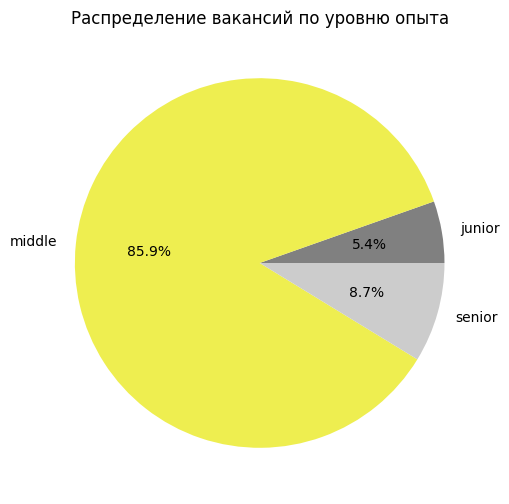

In [177]:
# Выполнение запроса и получение данных

query = """
WITH data_scientist_vacancies AS (
    SELECT * FROM public.vacancies
    WHERE
        (LOWER(name) LIKE '%data scientist%' OR
         LOWER(name) LIKE '%data science%' OR
         LOWER(name) LIKE '%исследователь данных%' OR
         LOWER(name) LIKE '%machine learning%' OR
         LOWER(name) LIKE '%машинн%обучен%' OR
         (LOWER(name) LIKE '%ml%' AND NOT LOWER(name) LIKE '%html%'))
)

SELECT
    experience,
    LENGTH(key_skills) - LENGTH(REPLACE(key_skills, CHR(9), '')) + 1 AS key_skills_num
FROM data_scientist_vacancies
WHERE key_skills IS NOT NULL;
"""

with connection.cursor() as cursor:
    cursor.execute(query)
    data = cursor.fetchall()

# Преобразование данных из кортежей в словари
data_dicts = [{"experience": row[0], "key_skills_num": row[1]} for row in data]

# Определение уровня и количества лет опыта
for item in data_dicts:
    if item["experience"] in ["Нет опыта", "Стажировка"]:
        item["level"] = "junior"
    elif item["experience"] == "От 1 года до 3 лет":
        item["level"] = "middle"
    elif item["experience"] == "От 3 до 6 лет":
        item["level"] = "middle"
    elif item["experience"] == "Более 6 лет":
        item["level"] = "senior"


# Разделение данных по уровням
junior_data = [item for item in data_dicts if item['level'] == 'junior']
middle_data = [item for item in data_dicts if item['level'] == 'middle']
senior_data = [item for item in data_dicts if item['level'] == 'senior']

# Группировка данных по уровням и вычисление среднего значения
levels = ['junior', 'middle', 'senior']
avg_key_skills = [np.mean([item['key_skills_num'] for item in data_dicts if item['level'] == level]) for level in levels]

# Подсчет количества вакансий для каждого уровня опыта
vacancies_count = [len(data) for data in [junior_data, middle_data, senior_data]]

# Создание круговой диаграммы
plt.figure(figsize=(8, 6))
plt.pie(vacancies_count, labels=levels, colors=['#808080', '#EEEE50', '#CCCCCC'], autopct='%1.1f%%')

# Настройка осей и легенды
plt.title('Распределение вакансий по уровню опыта')

# Отображение графика
plt.show()


Сложно сказать, чем вызван перекос количества вакансий по уровню опыта в сторону Middle, поскольку мне неизвестны параметры предоставленной выборки данных, но рискну предположить, что, в целом, соотношение действительно имеет место быть на рынке труда. 

Если выборка вакансий действительно репрезентативна, то распределение вакансий по уровням опыта может быть связано с несколькими факторами:

Большой спрос на Middle специалистов: Компании, возможно, ищут специалистов среднего уровня опыта, так как они уже обладают необходимыми навыками и опытом для работы над реальными проектами, но при этом стоят дешевле, чем Senior специалисты. Middle специалисты могут быстро вникнуть в задачи и начать работать над ними, обеспечивая компаниям баланс между затратами и результатами.

Меньший спрос на Junior специалистов: На начальном этапе карьеры специалисты часто сталкиваются с тем, что компаниям сложно уделить время на их обучение и развитие. В результате компании могут предпочесть нанимать более опытных специалистов, которые могут сразу начать работать над задачами.

Ограниченное количество вакансий для Senior специалистов: Вакансий для Senior специалистов может быть меньше, так как они занимают более высокие позиции и руководящие роли в компаниях. Такие позиции обычно ограничены и открываются реже, чем позиции для специалистов среднего уровня.

Карьерный рост внутри компаний: Компании часто предпочитают повышать своих сотрудников, давая им возможность расти внутри компании. В результате специалисты Junior и Middle уровня могут продвигаться по карьерной лестнице, что уменьшает количество вакансий для специалистов более высокого уровня.

Высокая текучесть кадров на рынке труда на момент выборки: В сфере IT и Data Science наблюдалась высокая текучесть кадров, и специалисты часто меняли работодателей. В результате компании испытывали постоянный спрос на Middle специалистов, чтобы заполнить возникающие вакансии.

Однако стоит учесть, что доля вакансий для Junior, Middle и Senior специалистов может варьироваться в зависимости от рынка.

Попробуем рассмотреть зависимость уровня опыта от среднего количества ключевых навыков. Посмотрим столбчатую диаграмму, что позволит визуализировать зависимость, а также наблюдать различия между уровнями вакансий.

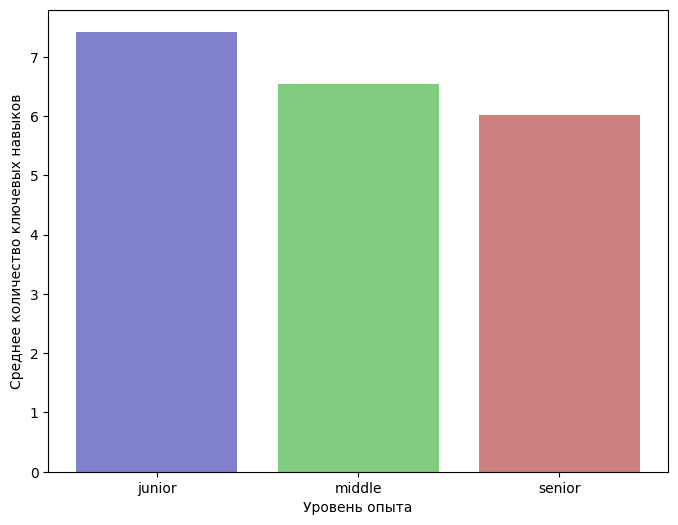

In [178]:
# Создание столбчатого графика
plt.figure(figsize=(8, 6))
plt.bar(levels, avg_key_skills, color=['#8080CC', '#80CC80', '#CC8080'])

# Настройка осей и легенды
plt.xlabel('Уровень опыта')
plt.ylabel('Среднее количество ключевых навыков')

# Отображение графика
plt.show()



In [179]:


query_avg_key_skills_by_level = f"""
WITH ds_vacancies AS (
    SELECT *
    FROM vacancies
    WHERE (
        LOWER(name) LIKE '%data scientist%'
        OR LOWER(name) LIKE '%data science%'
        OR LOWER(name) LIKE '%исследователь данных%'
        OR LOWER(name) LIKE '%machine learning%'
        OR name LIKE '%ML%' AND name NOT LIKE '%HTML%'
        OR LOWER(name) LIKE '%машинн%обучен%')
), key_skills_count AS (
    SELECT id, 
           (LENGTH(key_skills) - LENGTH(REPLACE(key_skills, CHR(9), ''))) / LENGTH(CHR(9)) + 1 as key_skills_num
    FROM ds_vacancies
    WHERE key_skills IS NOT NULL AND key_skills != ''
)
SELECT AVG(key_skills_num) as avg_key_skills, 
       (CASE
           WHEN experience = 'Нет опыта' OR employment = 'Стажировка' THEN 'Junior'
           WHEN experience = 'От 1 года до 3 лет' OR experience = 'От 3 до 6 лет' THEN 'Middle'
           ELSE 'Senior'
        END) as level
FROM key_skills_count
JOIN ds_vacancies ON ds_vacancies.id = key_skills_count.id
GROUP BY level;
"""

with connection.cursor() as cursor:
    cursor.execute(query_avg_key_skills_by_level)
    results = cursor.fetchall()
    print("Среднее количество ключевых навыков по уровням опыта:")
    for result in results:
        avg_key_skills, level = result
        print(f"{level}: {round(avg_key_skills, 2)}")


Среднее количество ключевых навыков по уровням опыта:
Senior: 5.94
Middle: 6.38
Junior: 7.42


Интересно, что в вакансиях для Junior Data Scientist указано больше ключевых навыков. Предположим, что это может быть связано с тем, что работодатели хотят обеспечить более широкий набор навыков для начинающих специалистов, чтобы у них был больший выбор областей для дальнейшего развития. С другой стороны, для более опытных специалистов ожидается более углубленное знание конкретных технологий или методик, поэтому количество ключевых навыков может быть меньше.

Чтобы выяснить причины, давайте выведем список наиболее часто встречающихся навыков для сеньоров, мидлов и джунов. Ниже написан код, который анализирует навыки для каждой группы и подсчитывает их встречаемость. Затем строится график с наиболее встречаемыми навыками для каждого уровня опыта.

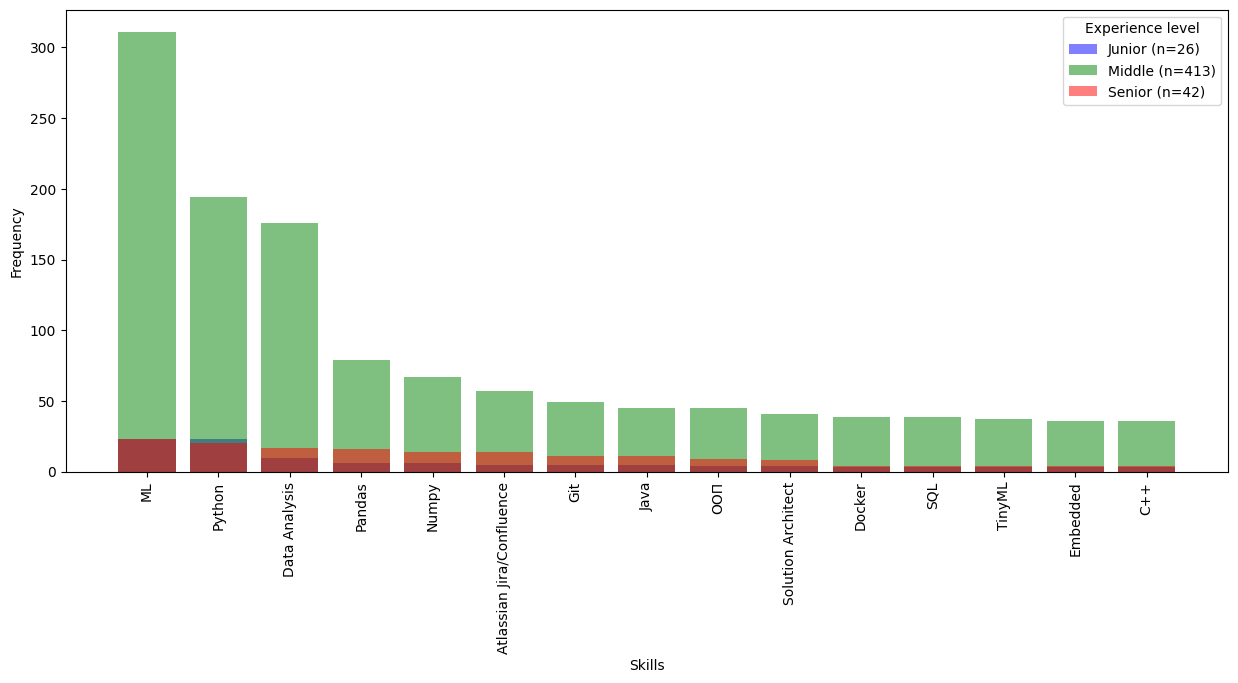

In [180]:
# Выполнение запроса и получение данных
query = """
WITH data_scientist_vacancies AS (
    SELECT * FROM public.vacancies
    WHERE
        (LOWER(name) LIKE '%data scientist%' OR
         LOWER(name) LIKE '%data science%' OR
         LOWER(name) LIKE '%исследователь данных%' OR
         LOWER(name) LIKE '%machine learning%' OR
         LOWER(name) LIKE '%машинн%обучен%' OR
         (LOWER(name) LIKE '%ml%' AND NOT LOWER(name) LIKE '%html%'))
)

SELECT
    experience,
    key_skills
FROM data_scientist_vacancies
WHERE key_skills IS NOT NULL;
"""

with connection.cursor() as cursor:
    cursor.execute(query)
    data = cursor.fetchall()

# Преобразование данных из кортежей в словари
data_dicts = [{"experience": row[0], "key_skills": row[1]} for row in data]

def extract_skills(data):
    skills = []
    for item in data:
        skill_list = split(r'\t', item['key_skills'])
        for skill in skill_list:
            if skill.lower() in ["machine learning", "машинное обучение"]:
                skill = "ML"
            elif skill.lower() == "анализ данных":
                skill = "Data Analysis"
            elif skill.lower() == "архитектор решений":
                skill = "Solution Architect"
            elif skill.lower() in ["atlassian jira", "atlassian confluence"]:
                skill = "Atlassian Jira/Confluence"
            skills.append(skill)
    return skills


def plot_most_common_skills(data, level, color, top_n=15):
    skills = extract_skills(data)
    counter = Counter(skills)
    most_common_skills = counter.most_common(top_n)

    labels, values = zip(*most_common_skills)
    indexes = np.arange(len(labels))

    plt.bar(indexes, values, color=color, alpha=0.5, label=f'{level} (n={len(data)})')
    plt.xticks(indexes, labels, rotation=90)
    plt.xlabel('Skills')
    plt.ylabel('Frequency')
    plt.legend(title='Experience level')

# Extract key_skills for each level
junior_data_dicts = [item for item in data_dicts if item['experience'] in ["Нет опыта", "Стажировка"]]
middle_data_dicts = [item for item in data_dicts if item['experience'] in ["От 1 года до 3 лет", "От 3 до 6 лет"]]
senior_data_dicts = [item for item in data_dicts if item['experience'] == "Более 6 лет"]

# Plot most common skills for each level
plt.figure(figsize=(15, 6))
plot_most_common_skills(junior_data_dicts, 'Junior', 'blue')
plot_most_common_skills(middle_data_dicts, 'Middle', 'green')
plot_most_common_skills(senior_data_dicts, 'Senior', 'red')
plt.show()



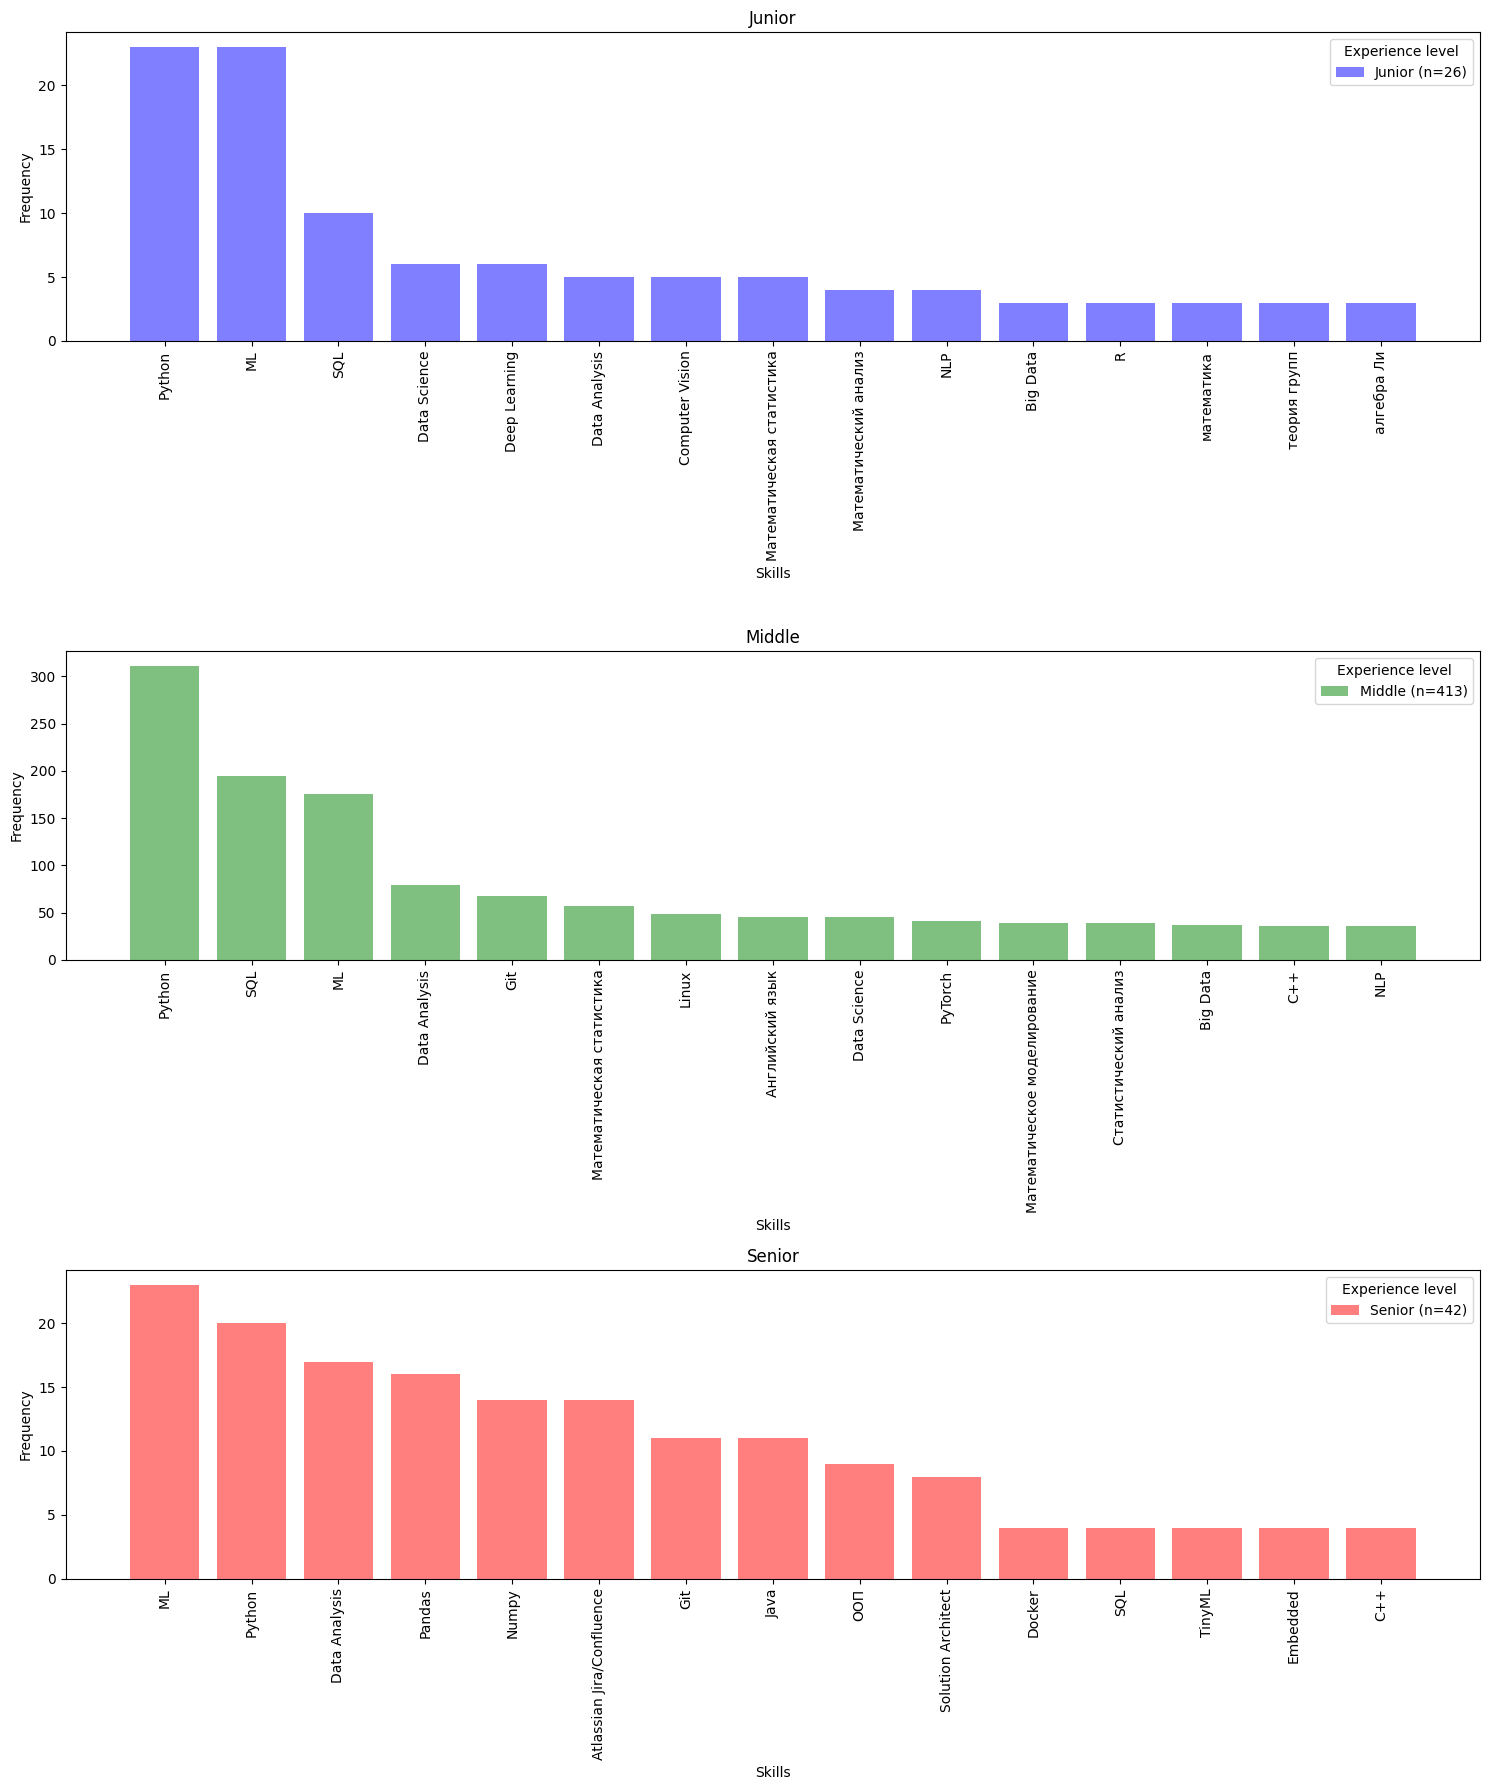

In [181]:
# Plot most common skills for each level
fig, axs = plt.subplots(3, 1, figsize=(15, 18))

# Junior
plt.sca(axs[0])
plot_most_common_skills(junior_data_dicts, 'Junior', 'blue')
axs[0].set_title('Junior')

# Middle
plt.sca(axs[1])
plot_most_common_skills(middle_data_dicts, 'Middle', 'green')
axs[1].set_title('Middle')

# Senior
plt.sca(axs[2])
plot_most_common_skills(senior_data_dicts, 'Senior', 'red')
axs[2].set_title('Senior')

# Adjust layout
plt.tight_layout()
plt.show()

In [182]:
def generate_skills_report(data, level):
    skills = extract_skills(data)
    counter = Counter(skills)
    most_common_skills = counter.most_common()

    print(f'{level.capitalize()} - Skills Report\n{"-" * 30}')

    for skill, count in most_common_skills:
        skill_share = count / len(data)
        print(f'{level.capitalize()} - {skill} - {skill_share:.2%}')

    print("\n")

# Генерация отчетов для каждого уровня опыта
generate_skills_report(junior_data_dicts, 'Junior')
generate_skills_report(middle_data_dicts, 'Middle')
generate_skills_report(senior_data_dicts, 'Senior')


Junior - Skills Report
------------------------------
Junior - Python - 88.46%
Junior - ML - 88.46%
Junior - SQL - 38.46%
Junior - Data Science - 23.08%
Junior - Deep Learning - 23.08%
Junior - Data Analysis - 19.23%
Junior - Computer Vision - 19.23%
Junior - Математическая статистика - 19.23%
Junior - Математический анализ - 15.38%
Junior - NLP - 15.38%
Junior - Big Data - 11.54%
Junior - R - 11.54%
Junior - математика - 11.54%
Junior - теория групп - 11.54%
Junior - алгебра Ли - 11.54%
Junior - прикладная математика - 11.54%
Junior - Jupiter - 11.54%
Junior - PyTorch - 11.54%
Junior - Git - 11.54%
Junior - Tensorflow - 11.54%
Junior - Английский язык - 11.54%
Junior - C++ - 7.69%
Junior - MS SQL - 7.69%
Junior - Numpy - 7.69%
Junior - Linux - 7.69%
Junior - Математическое моделирование - 7.69%
Junior - Java - 7.69%
Junior - MATLAB - 7.69%
Junior - Docker - 7.69%
Junior - Unix - 7.69%
Junior - Аналитическое мышление - 7.69%
Junior - Нейронные сети - 7.69%
Junior - Искусственный интелл

На основе представленных данных, можно сделать следующие выводы:

Python, SQL и Machine Learning (ML) являются самыми популярными навыками на всех уровнях опыта. Это связано с тем, что Python является основным языком программирования для анализа данных и машинного обучения, а SQL - основным инструментом для работы с базами данных.

С увеличением опыта специалистов, становится важным знание инструментов управления проектами и командной работы, таких как Atlassian Jira/Confluence, Git, Docker и т.д. Это связано с тем, что опытные специалисты чаще участвуют в больших проектах и командах.

Знание математической статистики, математического анализа, прикладной математики и аналитического мышления имеет большее значение для специалистов начального и среднего уровня. Это может быть связано с тем, что на более ранних стадиях карьеры специалисты активнее применяют свои теоретические знания для решения практических задач.

На более высоких уровнях опыта специалисты чаще сталкиваются с задачами управления проектами, построением архитектуры решений и т.д. Здесь более важными становятся навыки работы с различными технологиями и платформами, такими как Java, ООП, Solution Architect, Hadoop и другие.

Ежедневные задачи и проблемы специалистов в Data Science могут включать:

Junior: обработка и анализ данных, создание базовых моделей машинного обучения, изучение новых алгоритмов и инструментов, совершенствование теоретических знаний.

Middle: разработка более сложных моделей машинного обучения, оптимизация алгоритмов, работа с большими объемами данных, участие в проектах и командной работе, обучение младших специалистов.

Senior: построение архитектуры решений, управление проектами, разработка стратегий и рекомендаций для бизнеса, принятие ключевых решений, координация работы команды, исследование и внедрение новых технолнологий и подходов в области Data Science, менторство и развитие младших и средних специалистов.

Различия в основных ключевых навыках между специалистами разного уровня связаны с разными требованиями, которые предъявляются к специалистам на разных стадиях их карьеры.

Junior специалисты обычно только начинают свой путь в Data Science, и им требуется сильная основа в математике, статистике и основных языках программирования (Python, R). В этот период у них будет меньше опыта работы с большими проектами и командами, поэтому важно освоить базовые навыки.

Middle специалисты уже имеют определенный опыт и знания, и их задачи становятся более сложными. Они должны уметь работать с разнообразными инструментами, технологиями и платформами, такими как Git, Docker, Hadoop и другие. Также они начинают участвовать в командной работе и требуют навыков взаимодействия и координации.

Senior специалисты обладают глубокими знаниями и опытом в своей области, и их роль в команде часто связана с руководством и управлением проектами. Они должны быть способны координировать работу между различными командами, принимать ключевые решения и разрабатывать стратегии. Важными навыками для них становятся знание различных языков программирования, платформ, методологий и технологий, а также умение коммуницировать и обучать младших специалистов.

# Общий вывод по проекту

В ходе анализа вакансий по Data Science мы сделали следующие выводы:

1. Самые популярные ключевые навыки для специалистов по Data Science различаются в зависимости от уровня опыта. Python и машинное обучение являются наиболее важными навыками на всех уровнях, но старшие специалисты также обладают широким спектром других навыков, таких как разработка алгоритмов, анализ данных, опыт работы с большим объемом данных и т. д.

2. Распределение вакансий Data Scientist по уровню опыта: 5.4% для Junior, 85% для Middle и 8.7% для Senior. Это может быть связано с тем, что компании стремятся нанимать специалистов со средним уровнем опыта, которые уже имеют определенные навыки и могут быть более эффективными в решении задач.

3. Средняя зарплата Data Scientist'ов выше, чем у специалистов в других областях для каждого уровня опыта. Это может быть связано с тем, что Data Science является востребованной и специализированной областью, а также с более высоким порогом входа и специфическими навыками, необходимыми для выполнения работы.

Возможные направления для дополнительных исследований и продолжения исследования:

1. Исследовать влияние размера компании, отрасли и региона на зарплаты и требования к навыкам для Data Scientist'ов.

2. Проанализировать тенденции в области Data Science, чтобы предсказать, какие навыки и технологии будут наиболее востребованы в будущем.
Изучить мотивационные факторы, которые влияют на выбор карьеры Data Scientist'а, и определить возможные стратегии для привлечения и удержания талантов в области Data Science.

3.  Проанализировать рынок труда в целом, чтобы определить, какие другие профессии и области знаний могут предложить альтернативные или дополнительные возможности для специалистов в области Data Science и смежных областях.
Исследовать взаимосвязь между уровнем образования и успехом в карьере Data Scientist'ов, чтобы определить, какие образовательные программы и курсы могут быть наиболее полезными для будущих специалистов.

4. Изучить разнообразие в области Data Science с точки зрения пола, возраста, этнической принадлежности и других факторов, чтобы определить возможные проблемы и стратегии для улучшения равенства возможностей и представительства в этой области.

5. Оценить влияние различных менторских и образовательных программ на развитие карьеры специалистов в области Data Science и определить оптимальные пути для профессионального роста и развития.

6. Проанализировать вакансии в смежных областях, таких как Искусственный интеллект, Аналитика данных и Big Data, чтобы выявить возможности для кросс-функционального сотрудничества и перехода между областями.

7. Изучить спрос на специалистов в области Data Science в разных странах и регионах, чтобы определить географические различия и возможности для международного трудоустройства и сотрудничества.

Также можно наблюдать и продолжать рассматривать вопрос актуальности профессии Data Science в будущем, исходя из уже на данный момент сильно развитых возможностей искусственного интеллекта. 

 Вероятно, искусственный интеллект (AI) и автоматизация будут продолжать развиваться и внедряться в различные области, включая Data Science. Однако это не обязательно означает, что AI полностью заменит специалистов по Data Science.

Во-первых, AI в значительной степени помогает автоматизировать рутинные и трудоемкие задачи, что позволяет специалистам по Data Science сосредоточиться на более сложных и творческих аспектах работы, таких как выработка стратегий, интерпретация результатов и предложение решений на основе анализа данных.

Во-вторых, хотя AI может выполнять некоторые задачи быстрее и точнее, чем человек, он все еще зависит от экспертов по Data Science для создания и настройки моделей, обучения алгоритмов и мониторинга их эффективности.

В-третьих, AI может стать инструментом для расширения возможностей специалистов по Data Science и содействовать их профессиональному росту. Сотрудничество между людьми и машинами может привести к созданию новых методов анализа данных и решения проблем.

В заключение, искусственный интеллект, скорее всего, будет играть все большую роль в области Data Science, но вместо того чтобы полностью заменить специалистов, AI может изменить характер их работы и предоставить новые возможности для творчества, инноваций и сотрудничества.

# Финал

In [183]:
# закрытие соединения
connection.close()